# Result Analysis - Instruction Bias

This notebook has three goals to try to understand:
- How different prompts can influence the metrics?
- How different metrics reacts to differents prompts?
- How speicfy a more objective answer for different prompts influence the performance?


**Conclusions**
- The metrics used are problematic, without parsing even if the answer is right it doesnt seem to capture the expected result.
- ROUGE-l has problems with special character, which direct interfers with one type of task (dyck language)
- The prompt not include the specific instruction and induce to choose the right examples have a slightly positive effect in half of the tasks
- Affirmations about the proportion of samples from the target task cannot be made, inconclusive results
-  **Further experiments need to be made in order to test a perser and experiment differents types of metrics**

**Datasets**

We are using two different dataframe here to analyze the results, the Test Samples and the Results. 
</br>Test Samples' description:

| Column Name | Data Type | Description                              |
|-------------|-----------|------------------------------------------|
| task        | str       | Unique identifier for each task type     |
| input       | str       | Input prompt for that sample             |
| output      | str       | Ground-truth output                      |
| test_idx    | int64     | Unique indentifier                       |

</br>Results' description:

| Column Name | Data Type | Description                              |
|-------------|-----------|------------------------------------------|
| iter        | int64     | Iteration identifier                     |
| template    | int64     | Type of template indifier, being: (0) None (1) Prompt with Instruction, (2) Objective Prompt with Instruction, (3) Prompt without instruction, (4) Objectively prompt 3  |
| output      | int64     | Task ID's, being: (0) dyck_languages (1) desambiguation_qa, (2) web_of_lies, (3) word_sorting                    |
| proportion  | int64     | Identifiers of proortion of same task context intervals: (0) 0-2, (1) 3-6, (2) 7-8                 |
| output      | str       | Predicted Llama output                      |

**Methodology**

The results were obtained from the prediction of 5 different iterations where to a given task, proortion where randomly chosen three different subsets of contexts that satisfy the specifications. Then, we runned the inference of the Llama-3.1-8B-Instruct for each one of the types of template. The metrics used to measure the performance between the predicted and reference sentence are GLEU and ROUGE-l






In [1]:

import polars as pl
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import plotly.express as px
from src.utils.experiment_samplers import *
import os
from langchain.prompts import PromptTemplate
import json
from src.llms.Llama3_1_Instruct import Llama3_1_Instruct
from src.evaluator import GleuEvaluator, Rouge_L_evaluator
sns.set_theme(style="ticks", palette="pastel")



seed = 42
# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


/home/caio.rhoden/miniconda3/envs/datamodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "../../data/bbh_parser_experiment"

test = pl.read_ipc(f"{dataset_path}/test.feather")
results = pl.read_ipc(f"{dataset_path}/results/llama_parser.feather")



In [3]:
_test = (
    test
    .clone()
    .rename({"output": "true_output"})
    .with_columns(
        pl.arange(0, pl.len()).alias("test_idx")
    )
    .select(["input", "true_output", "test_idx"])
)


results = (
    results
    .rename({"output": "pred_output"})
    .join(_test, on = "test_idx", how = "left")
)

In [21]:


preds = results.select("pred_output").to_numpy().squeeze(1)
true = results.select("true_output").to_numpy().squeeze(1)


evaluator = GleuEvaluator()

glue = evaluator.evaluate(true, preds, None)
results = results.with_columns(pl.lit(glue).alias("gleu_evaluation"))

evaluator = Rouge_L_evaluator()
rouge = evaluator.evaluate(true, preds, None)
results = results.with_columns(pl.lit(rouge).alias("rouge_evaluation"))

## General Performance by Task and Instruction

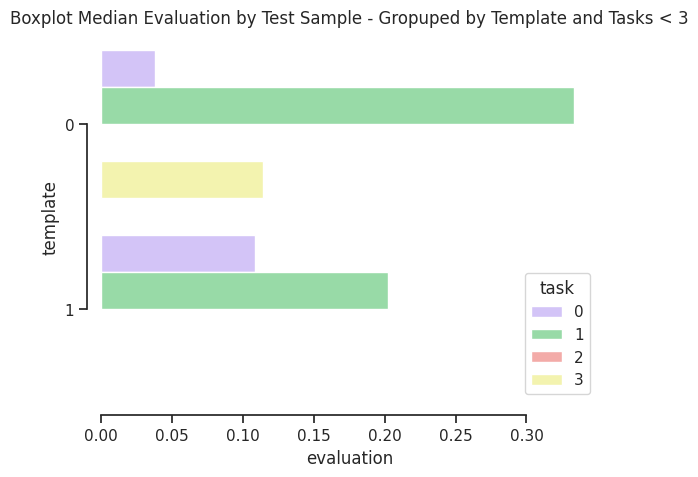

In [22]:
sns.set_theme(style="ticks", palette="pastel")


_plot1 = (
    results
    .select(["template", "task", "test_idx", "gleu_evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("gleu_evaluation").alias("evaluation"))
    .group_by(["template", "task"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.barplot(
                data=_plot1, 
                y="template", 
                x="evaluation", 
                hue="task", 
                orient="h", 
                palette=["m", "g", "r", "y"]
        ).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks < 3')


sns.despine(offset=10, trim=True)

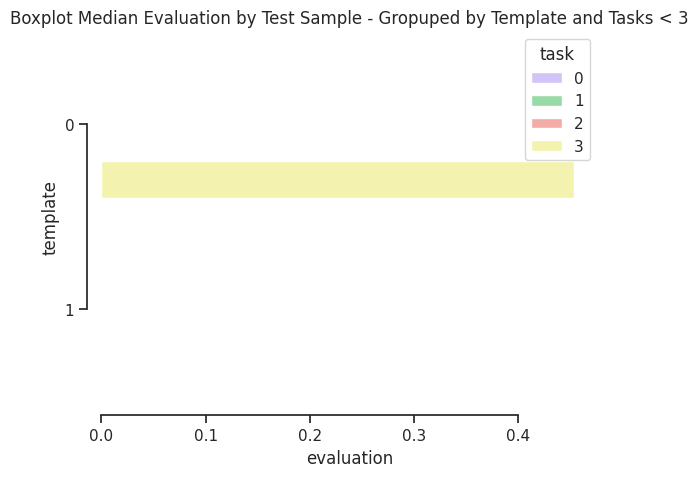

In [23]:
_plot1 = (
    results
    .select(["template", "task", "test_idx", "rouge_evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("rouge_evaluation").alias("evaluation"))
    .group_by(["template", "task"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.barplot(
                data=_plot1, 
                y="template", 
                x="evaluation", 
                hue="task", 
                orient="h", 
                palette=["m", "g", "r", "y"]
        ).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks < 3')


sns.despine(offset=10, trim=True)

In [24]:
results

iter,template,test_idx,task,proportion,pred_output,input,true_output,evaluation,gleu_evaluation,rouge_evaluation
i64,i64,i64,i64,i64,str,str,str,f64,f64,f64
0,0,18,0,0,"""( )""","""Complete the rest of the seque…",""">""",0.0,0.0,0.0
0,1,18,0,0,"""n""","""Complete the rest of the seque…",""">""",0.0,0.0,0.0
0,0,18,0,0,"""""","""Complete the rest of the seque…",""">""",0.0,0.0,0.0
0,1,18,0,0,""")}""","""Complete the rest of the seque…",""">""",0.0,0.0,0.0
0,0,18,0,0,"""['>']""","""Complete the rest of the seque…",""">""",0.071429,0.071429,0.0
…,…,…,…,…,…,…,…,…,…,…
4,1,39,3,1,"""['abuilding', 'burgher']""","""Sort the following words alpha…","""advent anger convoy deliver fi…",0.0,0.0,0.0
4,0,39,3,1,"""['advent anger convoy deliver …","""Sort the following words alpha…","""advent anger convoy deliver fi…",0.243243,0.243243,0.571429
4,1,39,3,1,"""barn damp delmarva dot drumhea…","""Sort the following words alpha…","""advent anger convoy deliver fi…",0.0,0.0,0.0
